In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()

# Separation prediction

In this section we will combine the vortex panel method and the boundary layer solver to predict separation on any 2D shape.

## Panel method and boundary layer coupling

What will we need to interface the `VortexPanel` and `BoundaryLayer` modules?  

The external flow doesn't need anything from `BoundaryLayer` - it just needs a geometry and angle of attack:

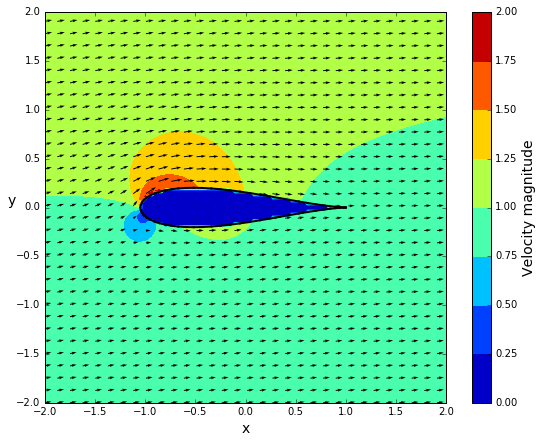

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

import VortexPanel as vp
import BoundaryLayer as bl

alpha = numpy.pi/20
foil = vp.make_jukowski(N=64)
foil.solve_gamma_kutta(alpha)
foil.plot_flow()

From the previous notebook we know the function `march` doesn't need the details of the geometry, but it does need:

- $s$: the distance along the boundary layer
- $u_e$: the velocity on the edge of the boundary layer
- $\nu$: the kinematic viscosity (given by Reynolds number)

We'll need to get the first two from the potential flow solution.

---


Getting the velocity is surprisingly simple. The total jump in tangential velocity across the panel is $\Delta u_s=-\gamma$. Since $u_s=0$ on the body side of the panel after `solve`ing, the tangential velocity on the flow side of the panel is simply 

$$u_s(x_i,y_i) = -\gamma_i$$

and the external velocity is $u_e=|u_s|$.

---

Now that we know how to get the velocity, we need to think about the distance along the BL, $s$. Note that a body will form **two** boundary layers, one on each side. We need to identify the starting point of these two flow regions.

##### Quiz

Where is the starting point of the two boundary layers?

1. The first panel: `foil[0]`
1. The panel where $u_s = 0$
1. The left-most panel, `foil[N/2]`


This makes it straightforward to split the body into the two boundary layer sections:
```python
def split(self):
    top = [p for p in self.panels if p.gamma<=0]
    bot = [p for p in self.panels if p.gamma>=0]
    return PanelArray(top),PanelArray(bot[::-1])
```
Note that we changed the direction of the bottom array so that it runs from the stagnation point to the trailing edge to match the flow direction.

This is implemented in the `PanelArray.split` function. Let's use the example code to test the `split` function:

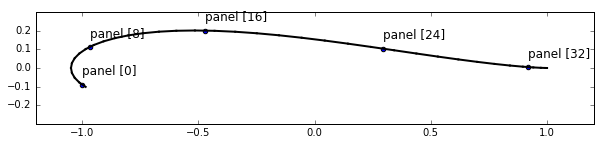

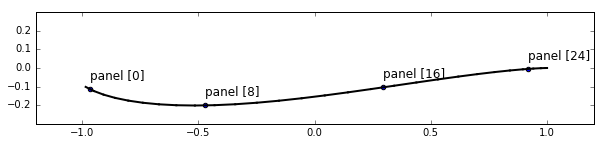

In [9]:
foil = vp.make_jukowski(N=64)        #1. Define the geometry
foil.solve_gamma_kutta(alpha=0.2)    #2. Solve for the potential flow
foil_top,foil_bot = foil.split()     #3. Split the boundary layers

def plot_segment(segment):
    pyplot.figure(figsize=(10,2))
    pyplot.axis([-1.2,1.2,-.3,.3])
    for i,p_i in enumerate(segment.panels): 
        p_i.plot()
        if i%8 == 0:
            pyplot.scatter(p_i.xc,p_i.yc)
            pyplot.text(p_i.xc,p_i.yc+0.05, 
                'panel ['+'%i'%i+']',fontsize=12)
    pyplot.show()

plot_segment(foil_top)
plot_segment(foil_bot)

As we change `alpha`, the stagnation point - and therefore the panels in each section - changes.

---

Once the sections are `split` we can feed them to `PanelArray.march`. Again, only three lines of code:
```python
def march(self, nu, thwaites=False):
    s = self.distance()                      # distance
    u_e = abs(self.get_array("gamma"))       # velocity
    return bl.march(s, u_e, nu, thwaites)       # march
```

In [4]:
help(foil.march)

Help on method march in module VortexPanel:

march(nu, thwaites=False) method of VortexPanel.PanelArray instance
    March along a set of BL panels
    
    Inputs:
    nu       -- kinematic viscosity
    thwaites -- Thwaites approximate method flag (default=False)
    
    Outputs:
    delta2 -- array momentum thicknesses at panel centers
    lam    -- array of shape function values at panel centers
    iSep   -- array index of separation point
    
    Examples:
    nu = 1e-5
    circle = vp.make_circle(N=64)     #1. make the geometry
    circle.solve_gamma()              #2. solve the pflow
    top,bottom = circle.split()       #3. split the panels
    delta2,lam,iSep = top.march(nu)   #4. march along the BL



## Boundary layer around a circle

Lets run the example in the docstring as our first application: the boundary layer on a circle.

##### Quiz

Why do I keep testing code on simple shapes like circles?

1. I'm terribly forgetful
1. New examples take work
1. **I want to validate the new code**

##### Numerical fundamental: Validation
##### Every piece of code must be tested against a known nontrivial example

---

![short](resources/graphics3.png)
---

So lets validate the results. The *theoretical* laminar separation point for a circular cylinder is $108\deg$ from the leading stagnation point. For a circle has radius $R=1$, this corresponds to $s=1.88$. Lets check the simulation by plotting $\lambda$. 

__Notice there are 4 steps in solving the BL flow:__

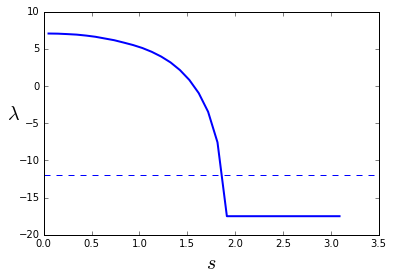

In [12]:
# set up and solve circle BL flow:
nu = 1e-5
circle = vp.make_circle(N=64)     #1. make the geometry
circle.solve_gamma()              #2. solve the pflow
top,bottom = circle.split()       #3. split the panels
delta2,lam,iSep = top.march(nu)   #4. march along the BL

# plot lambda(s)
s = top.distance()
pyplot.ylabel(r'$\lambda$', fontsize=20, rotation=0)
pyplot.xlabel(r'$s$', fontsize=20)
pyplot.plot(s,lam,lw=2)
pyplot.axhline(-12,ls='--')

As you move along the boundary layer, $\lambda$ decreases from the initial stagnation point condition of $\lambda_0\approx7$ and eventually crosses the threshold for separation $\lambda=-12$. Values after separation are meaningless.

From the plot we can see separation occurs between $1.7<s<2$, but this is too vague. We need a specific prediction and we can use `iSep` to get one. If `iSep=13.2` it means that separation occured 20% of the way between `s[13]` and `s[14]`. All we need to do is interpolate, and we can do this for __any__ panel attribute, not just `s`:
```python
def sep(y,iSep):
    i = math.ceil(iSep)           # round up to nearest integer
    di = i-iSep                   # interpolation `distance`
    return y[i-1]*di+y[i]*(1-di)  # linearly interpolate
```
This is the `BoundaryLayer.sep` function. Let's see what we get:

In [6]:
sSep = bl.sep(s,iSep)
print('analytic prediction @ s=1.88 \n numeric prediction @ s={:.2f}'.format(sSep))

analytic prediction @ s=1.88 
 numeric prediction @ s=1.86


Our numerical method prediction is one percent different than the theoretical result!

##### Quiz

How does the separation point depend on $\nu$?

1. Increasing $\nu$ delays separation
1. Decreasing $\nu$ delays separation
1. Changing $\nu$ has no effect on separation

---

Is this a bug??

We know from lectures that $\delta$ scales as $\sqrt\nu$, and therefore $\lambda=\frac{\delta^2}\nu u_e'$ doesn't depend on $\nu$ at all. Since the separation point is determined by $\lambda$, this is also independent of $\nu$.

##### Fluids fundamental: Separation Point
##### The point of laminar separation is independent of $Re$

This is **not** true of a turbulent boundary layer.

## Separation of the foil

Finally, let's solve for the boundary layer separation points on the foil using the `PanelArray.sep_point` function. It is another 3 liner:
```python
def sep_point(self):
    delta2,lam,iSep = self.march(1)
    x,y = self.get_array('xc','yc')
    return bl.sep(x,iSep),bl.sep(y,iSep)
```
 Note this function doesn't depend on $\nu$ because... Quiz 3

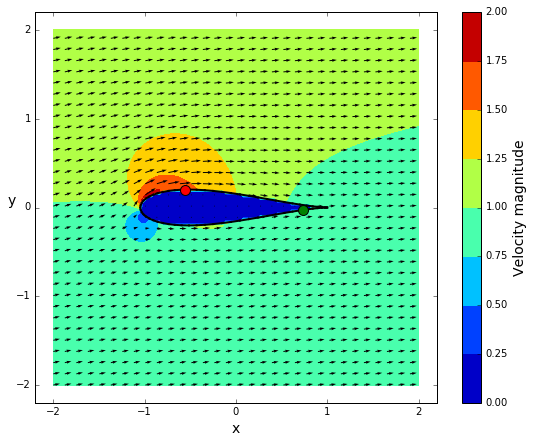

In [7]:
alpha = numpy.pi/18
foil = vp.make_jukowski(N=64)       #1. make the geometry
foil.solve_gamma_kutta(alpha)       #2. solve the pflow
top,bot = foil.split()              #3. split the panels
x_top,y_top = top.sep_point()       #4. find separation on top 
x_bot,y_bot = bot.sep_point()       #   ... and bottom BL

foil.plot_flow()
pyplot.scatter(x_top,y_top, s=100, c='r', zorder=10)
pyplot.scatter(x_bot,y_bot, s=100, c='g', zorder=10)
pyplot.show()

And we see that at an angle of attack, the high pressure side of the foil (the bottom) has delayed separation, while the low pressure side has early separation. This is exactly the kind of information we need to predict stall.

---

## Summary 

Let's review the general solution methodology again: 

1. `make` the geometry as a set of vortex panels
1. `solve` the potential flow by applying the no-slip and kutta conditions
1. `split` the panels into sections on either side of the stagnation points
1. `march` the boundary layer equations to the point of separation

Then you can measure, print, or plot any flow quantity you want. 

##### Numerical fundamental: Synergy
##### Simple functions can be linked to build powerful methods

By combining the `VortexPanel` methods with the `BoundaryLayer.march` method, we've developed a numerical tool to predict separation on **any** body (or group of bodies).

## Aspect ratio validation

We've validated the code for the known case of a circle, but this is just one geometry. 

##### Numerical fundamental: Skepticism
##### "That is what the computer said..." - Famous last words

We should validate a new method on as many known results as possible. 

One thing we could validate is that the separation points change properly if the aspect ratio $t/c$ is changed.  Here is a summary figure from Chapter 3 of Hoerner's *Fluid-Dynamic Drag*

---
![Hoerner Drag, Fig 5, Chap 3](resources/separation_hoerner.png)

---
There are four ellipse examples and two Jukowski examples. Based on this figure, I estimate:

Jukowski foil:

$t/c$| 0.17  | 0.15 
---|
$x/c$| $0.39$  | $0.49$ 

Ellipse:

$t/c$| 1 |1/2 | 1/4 | 1/6 | 1/8 
---|
$x/c$| $0.65$ | $0.75$ | $0.85$ | $0.89$ | $0.92$ 

where $x$ is the linear distance from the nose to the point of separation. I've included the result for a circle.

##### Your turn #5

Validate the separation prediction method against these two families of geometries. 

 - **Predict** separation for the Jukowski cases, being sure to match $t/c$.
 - **Predict and Plot** $x/c$ for the ellipse for $t/c$=`linspace(0.08,1.1,10)` compared to Hoerner's data. 
 - **Discuss** the results with regards to validation and trends. Are these adequate to validate the numerical method? Are there any surprises?

I recommend that you write a few functions to help automate the prediction process, similar to the previous notebooks...

##### Solution #5


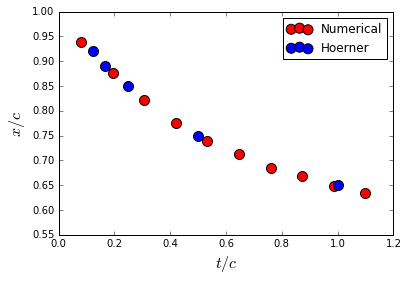

In [146]:
# function definitions
def t_c(geom):
    xc,yc = geom.get_array('xc','yc')
    t = max(yc) - min(yc)
    c = max(xc) - min(xc)
    return t/c

def x_c(geom):
    xc = geom.get_array('xc')
    c = max(xc) - min(xc)
    geom.solve_gamma_kutta()
    top,_ = geom.split()
    xt = top.sep_point()[0] - min(xc)
    return xt/c

# x/c for the foils using vp.make_jukowski
dx = [0.1310202, 0.1513738] # found by trial and error using t_c()
foils = [vp.make_jukowski(64,x) for x in dx]

# x/c for the ellipses using vp.make_ellipse
t_c = numpy.linspace(0.08,1.1,10)
ellipses = [vp.make_ellipse(64,i) for i in t_c]

# plot
pyplot.scatter(t_c[::1],
               [x_c(g) for g in ellipses],
               100, 'r', label='Numerical')

pyplot.scatter([1,1./2.,1./4.,1./6.,1./8.],
               [0.65,0.75,0.85,0.89,0.92], 
               s=100, label='Hoerner')

pyplot.legend(loc='upper right')
pyplot.xlabel(r'$t/c$', fontsize=16)
pyplot.ylabel(r'$x/c$', fontsize=16)

In [144]:
# print percentage error for 17% prediction
print((x_c(foils[1])-0.39)/x_c(foils[1]) * 100)

# get specific value
print(x_c(vp.make_ellipse(64,0.6)))

14.431420754
0.722160616911
